In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import math

In [9]:
def calculate_FTTSE(energy, time, is_training=True):
    if is_training:
        return energy * (time**2)
    else:
        return energy * math.exp(time)
    
def calculate_G_score(alpha, beta, gamma, f1, train, inference):
    return alpha * f1 + beta * (1-train) + gamma * (1-inference)

In [3]:
df = pd.read_csv("mock_experiment_data.csv")
averages_df = df.groupby("Model").mean().reset_index()

averages_df['FTTSE_Training'] = averages_df.apply(
    lambda row: calculate_FTTSE(row['Training_Energy_Joules'], row['Training_Time_Seconds'], is_training=True), axis=1)

averages_df['FTTSE_Inference'] = averages_df.apply(
    lambda row: calculate_FTTSE(row['Inference_Energy_Joules'], row['Inference_Time_Seconds'], is_training=False), axis=1)

print(averages_df)

                 Model  Trial  Training_Time_Seconds  Training_Energy_Joules  \
0        Decision Tree   10.5             282.641147              342.631969   
1  Logistic Regression   10.5             294.772254              256.688262   
2          Naive Bayes   10.5             282.229170              300.793162   
3                  SVM   10.5             241.580659              291.881735   

   Inference_Time_Seconds  Inference_Energy_Joules  F1_Score  FTTSE_Training  \
0                0.050474                30.548505  0.756857    2.737150e+07   
1                0.049350                23.566194  0.741512    2.230382e+07   
2                0.054262                23.707642  0.742665    2.395917e+07   
3                0.054138                29.472495  0.705641    1.703457e+07   

   FTTSE_Inference  
0        32.129974  
1        24.758355  
2        25.029619  
3        31.112054  


In [4]:
# Calculate the minimum and maximum FTTSE values
FTTSE_train_min, FTTSE_train_max = averages_df["FTTSE_Training"].min(), averages_df["FTTSE_Training"].max()
FTTSE_inference_min, FTTSE_inference_max = averages_df["FTTSE_Inference"].min(), averages_df["FTTSE_Inference"].max()

# Normalize the FTTSE values
averages_df["FTTSE_Training_norm"] = (averages_df["FTTSE_Training"] - FTTSE_train_min) / (FTTSE_train_max - FTTSE_train_min)
averages_df["FTTSE_Inference_norm"] = (averages_df["FTTSE_Inference"] - FTTSE_inference_min) / (FTTSE_inference_max - FTTSE_inference_min)

print(averages_df)

                 Model  Trial  Training_Time_Seconds  Training_Energy_Joules  \
0        Decision Tree   10.5             282.641147              342.631969   
1  Logistic Regression   10.5             294.772254              256.688262   
2          Naive Bayes   10.5             282.229170              300.793162   
3                  SVM   10.5             241.580659              291.881735   

   Inference_Time_Seconds  Inference_Energy_Joules  F1_Score  FTTSE_Training  \
0                0.050474                30.548505  0.756857    2.737150e+07   
1                0.049350                23.566194  0.741512    2.230382e+07   
2                0.054262                23.707642  0.742665    2.395917e+07   
3                0.054138                29.472495  0.705641    1.703457e+07   

   FTTSE_Inference  FTTSE_Training_norm  FTTSE_Inference_norm  
0        32.129974             1.000000              1.000000  
1        24.758355             0.509749              0.000000  
2     

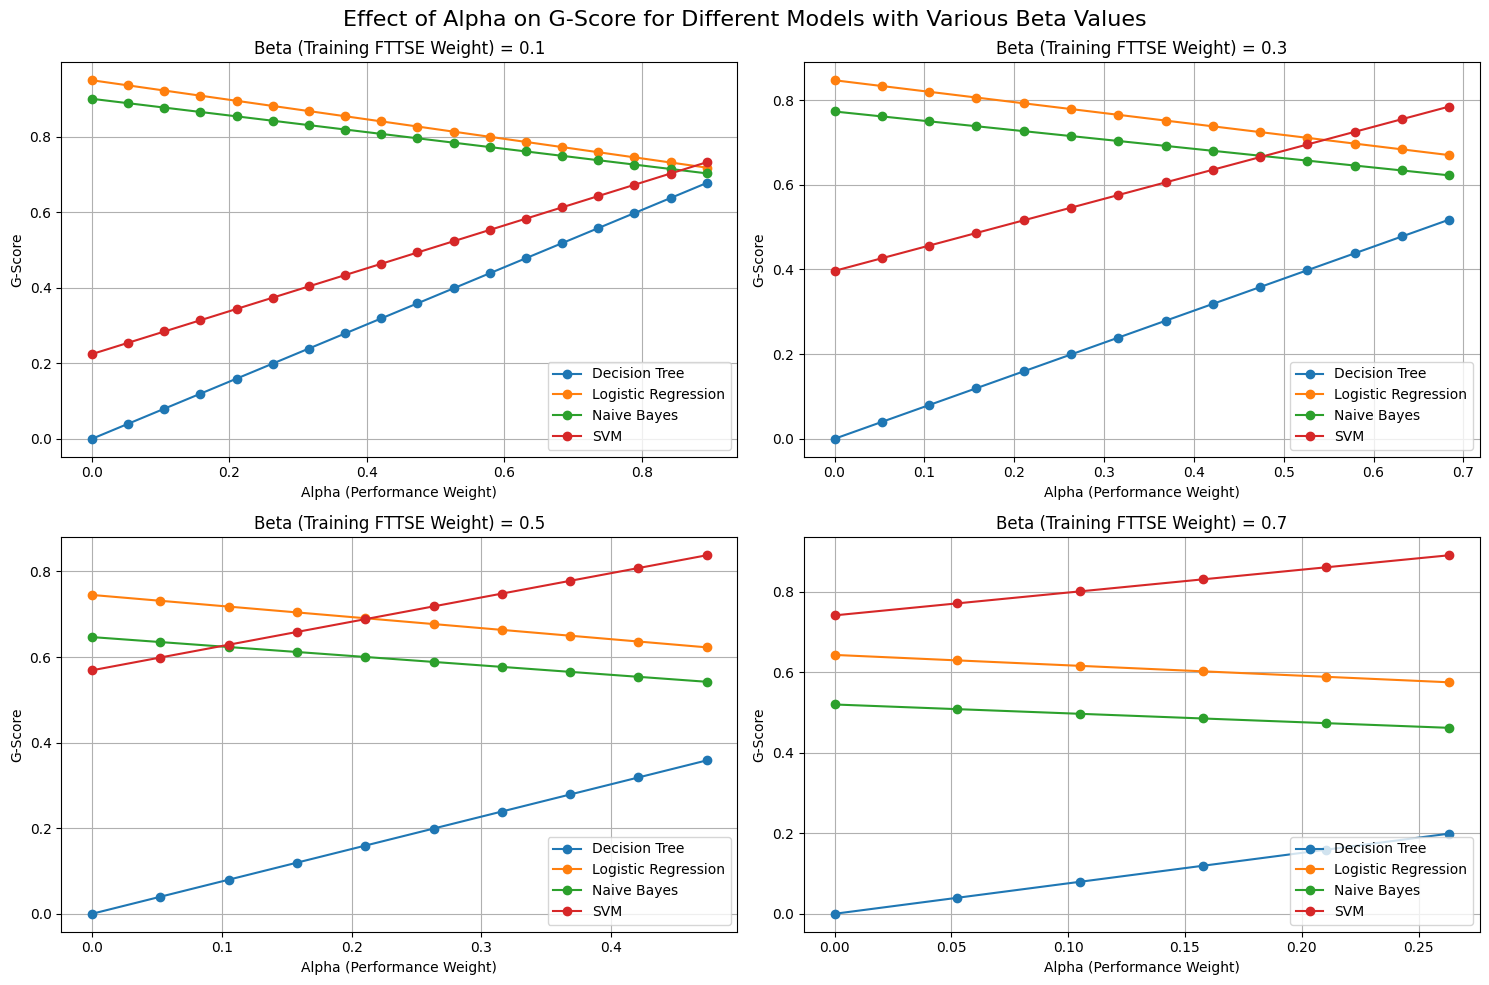

In [10]:
alpha_values = np.linspace(0, 1, 20)
beta_values = [0.1, 0.3, 0.5, 0.7]

# Create a 2x2 grid of subplots
fig, axs = plt.subplots(2, 2, figsize=(15, 10))
axs = axs.flatten()

for idx, beta_value in enumerate(beta_values):
    ax = axs[idx]

    for model in averages_df["Model"]:
        f1 = averages_df[averages_df["Model"] == model]["F1_Score"].values[0]
        train = averages_df[averages_df["Model"] == model]["FTTSE_Training_norm"].values[0]
        inference = averages_df[averages_df["Model"] == model]["FTTSE_Inference_norm"].values[0]

        g_scores = []
        for alpha in alpha_values:
            gamma_value = 1 - alpha - beta_value
            if gamma_value >= 0:
                g_score = calculate_G_score(alpha, beta_value, gamma_value, f1, train, inference)
                g_scores.append(g_score.mean())
            else:
                g_scores.append(np.nan)

        # Plot the effect of alpha on G-score
        ax.plot(alpha_values, g_scores, marker='o', label=f'{model}')

    # Add labels, title, and legend
    ax.set_xlabel('Alpha (Performance Weight)')
    ax.set_ylabel('G-Score')
    ax.set_title(f'Beta (Training FTTSE Weight) = {beta_value}')
    ax.grid(True)
    ax.legend()

fig.suptitle('Effect of Alpha on G-Score for Different Models with Various Beta Values', fontsize=16)
plt.tight_layout()
plt.show()

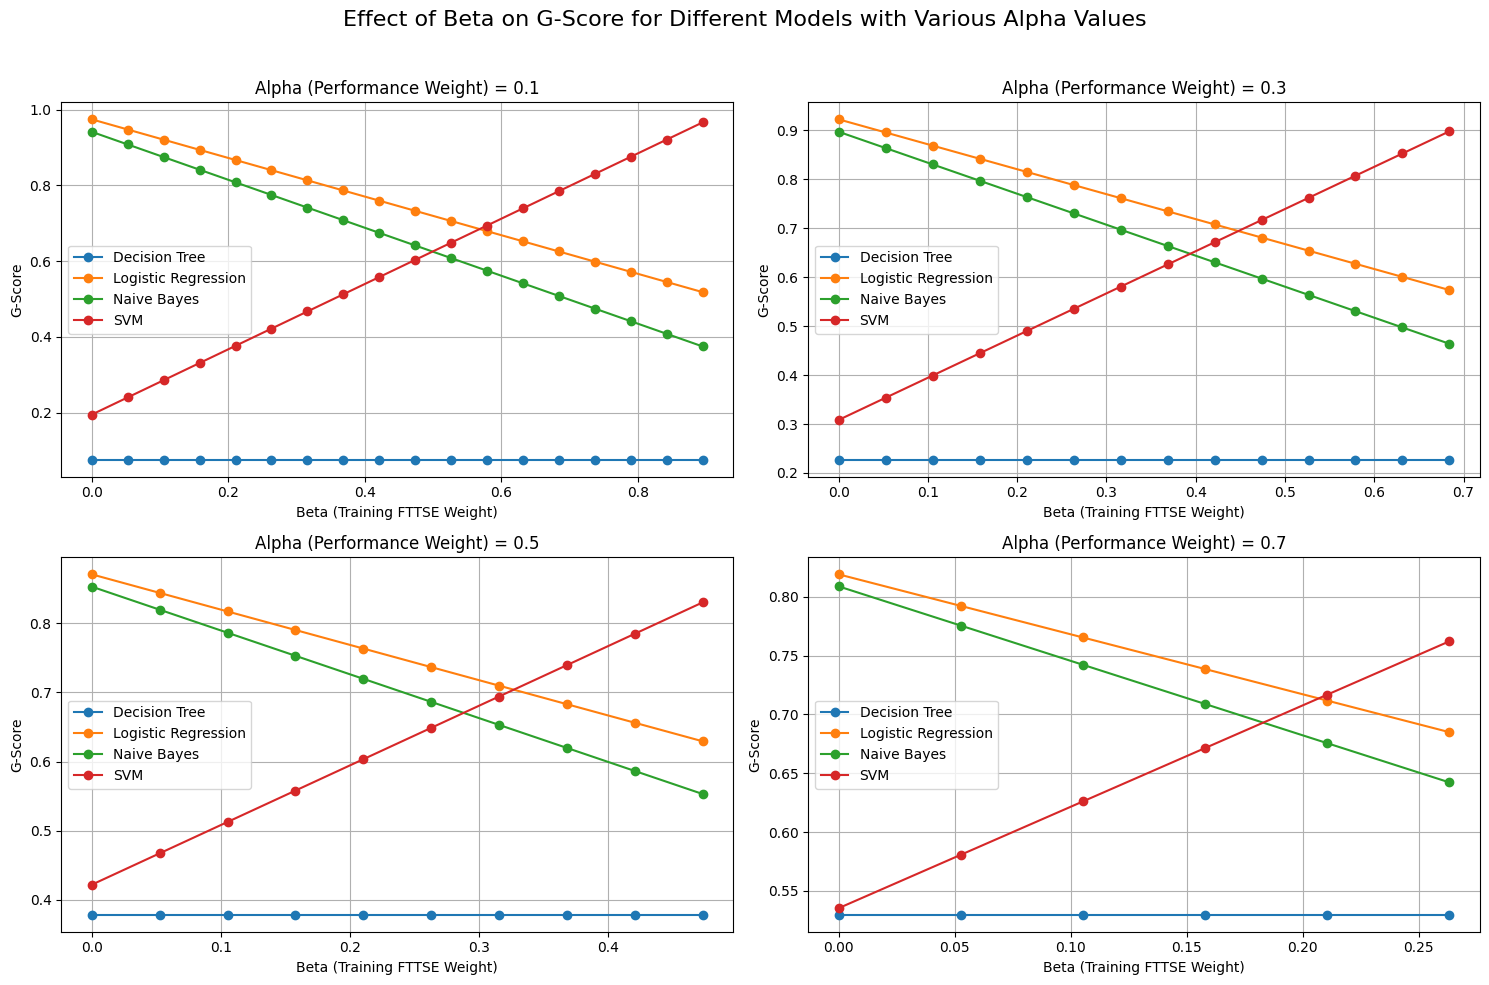

In [11]:
beta_values = np.linspace(0, 1, 20)
alpha_values = [0.1, 0.3, 0.5, 0.7]

# Create a 2x2 grid of subplots
fig, axs = plt.subplots(2, 2, figsize=(15, 10))
axs = axs.flatten()

for idx, alpha_value in enumerate(alpha_values):
    ax = axs[idx]

    for model in averages_df["Model"]:
        f1 = averages_df[averages_df["Model"] == model]["F1_Score"].values[0]
        train = averages_df[averages_df["Model"] == model]["FTTSE_Training_norm"].values[0]
        inference = averages_df[averages_df["Model"] == model]["FTTSE_Inference_norm"].values[0]

        g_scores = []
        for beta_value in beta_values:
            gamma_value = 1 - alpha_value - beta_value
            if gamma_value >= 0:
                g_score = calculate_G_score(alpha_value, beta_value, gamma_value, f1, train, inference)
                g_scores.append(g_score.mean())
            else:
                g_scores.append(np.nan)

        # Plot the effect of beta on G-score
        ax.plot(beta_values, g_scores, marker='o', label=f'{model}')

    # Add labels, title, and legend
    ax.set_xlabel('Beta (Training FTTSE Weight)')
    ax.set_ylabel('G-Score')
    ax.set_title(f'Alpha (Performance Weight) = {alpha_value}')
    ax.grid(True)
    ax.legend()

# Set the title for the entire figure
fig.suptitle('Effect of Beta on G-Score for Different Models with Various Alpha Values', fontsize=16)
plt.tight_layout(rect=[0, 0, 1, 0.96])  # Adjust layout to make room for the suptitle
plt.show()

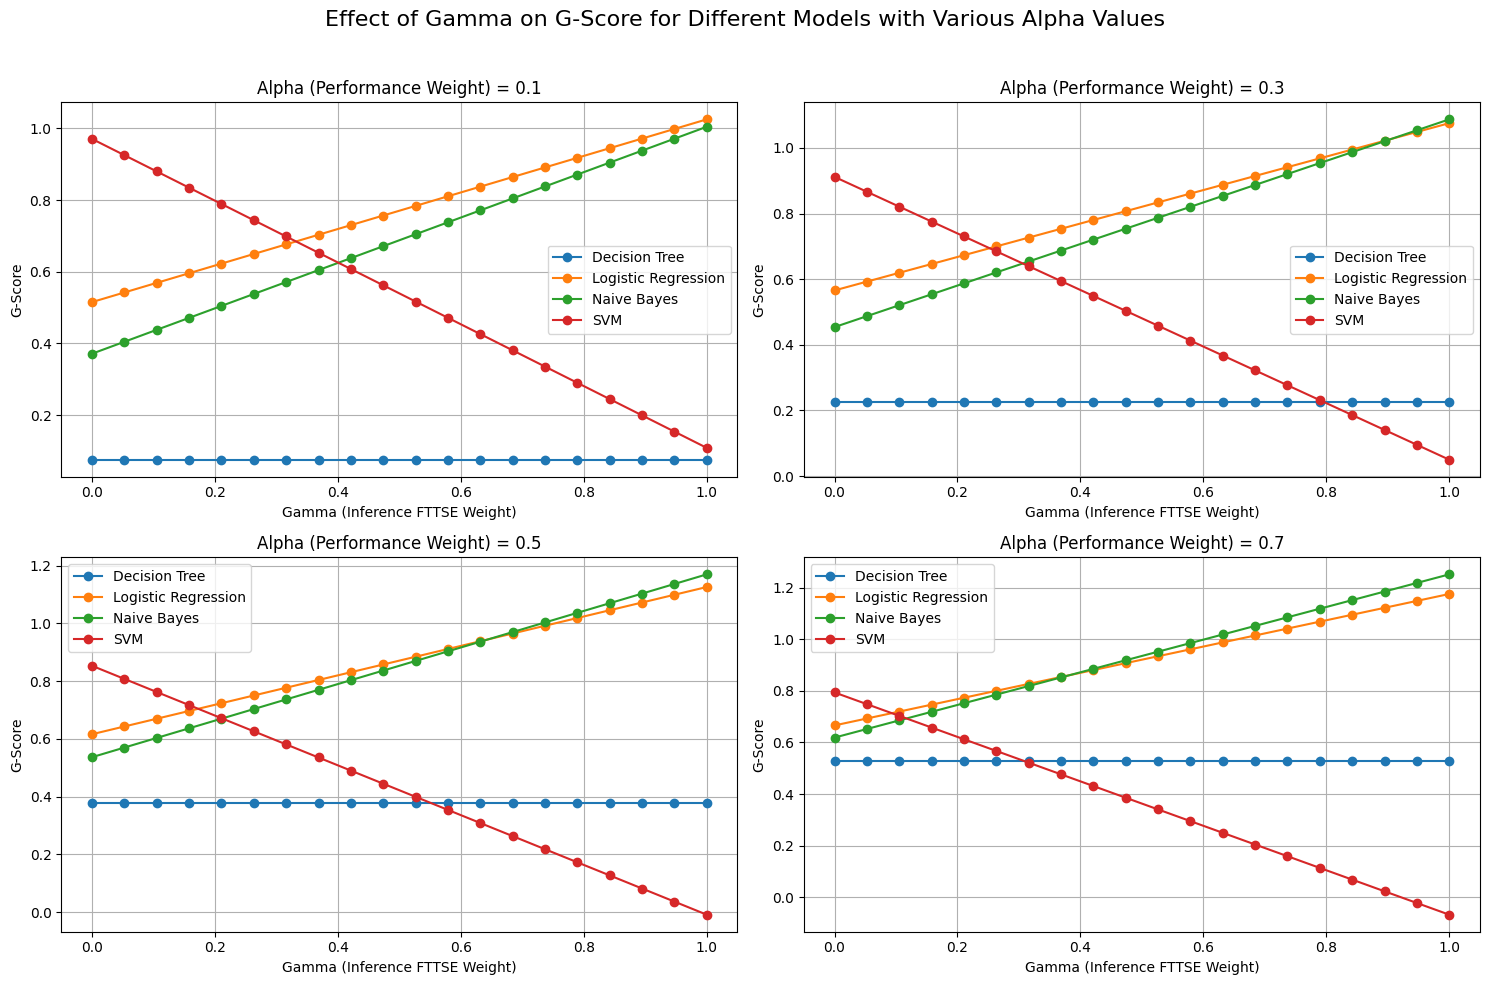

In [12]:
gamma_values = np.linspace(0, 1, 20)
alpha_values = [0.1, 0.3, 0.5, 0.7]

# Create a 2x2 grid of subplots
fig, axs = plt.subplots(2, 2, figsize=(15, 10))
axs = axs.flatten()

for idx, alpha_value in enumerate(alpha_values):
    ax = axs[idx]

    for model in averages_df["Model"]:
        f1 = averages_df[averages_df["Model"] == model]["F1_Score"].values[0]
        train = averages_df[averages_df["Model"] == model]["FTTSE_Training_norm"].values[0]
        inference = averages_df[averages_df["Model"] == model]["FTTSE_Inference_norm"].values[0]

        g_scores = []
        for gamma_value in gamma_values:
            beta_value = 1 - alpha_value - gamma_value
            if gamma_value >= 0:
                g_score = calculate_G_score(alpha_value, beta_value, gamma_value, f1, train, inference)
                g_scores.append(g_score.mean())
            else:
                g_scores.append(np.nan)

        # Plot the effect of gamma on G-score
        ax.plot(gamma_values, g_scores, marker='o', label=f'{model}')

    # Add labels, title, and legend
    ax.set_xlabel('Gamma (Inference FTTSE Weight)')
    ax.set_ylabel('G-Score')
    ax.set_title(f'Alpha (Performance Weight) = {alpha_value}')
    ax.grid(True)
    ax.legend()

# Set the title for the entire figure
fig.suptitle('Effect of Gamma on G-Score for Different Models with Various Alpha Values', fontsize=16)
plt.tight_layout(rect=[0, 0, 1, 0.96])  # Adjust layout to make room for the suptitle
plt.show()

In [13]:
import numpy as np
import matplotlib.pyplot as plt
from ipywidgets import interact, FloatSlider

def plot_alpha_vs_g_score(beta_value):
    fig, ax = plt.subplots(figsize=(8, 6))

    for model in averages_df["Model"]:
        f1 = averages_df[averages_df["Model"] == model]["F1_Score"].values[0]
        train = averages_df[averages_df["Model"] == model]["FTTSE_Training_norm"].values[0]
        inference = averages_df[averages_df["Model"] == model]["FTTSE_Inference_norm"].values[0]

        g_scores = []
        for alpha in alpha_values:
            gamma_value = 1 - alpha - beta_value
            if gamma_value >= 0:
                g_score = calculate_G_score(alpha, beta_value, gamma_value, f1, train, inference)
                g_scores.append(g_score.mean())
            else:
                g_scores.append(np.nan)

        ax.plot(alpha_values, g_scores, marker='o', label=f'{model}')

    ax.set_xlabel('Alpha (Performance Weight)')
    ax.set_ylabel('G-Score')
    ax.set_title(f'Effect of Alpha on G-Score with Beta = {beta_value}')
    ax.legend()
    ax.grid(True)
    plt.show()

# Create an interactive widget to control beta
interact(plot_alpha_vs_g_score, beta_value=FloatSlider(min=0.1, max=0.7, step=0.1, value=0.3))


interactive(children=(FloatSlider(value=0.3, description='beta_value', max=0.7, min=0.1), Output()), _dom_clas…

<function __main__.plot_alpha_vs_g_score(beta_value)>

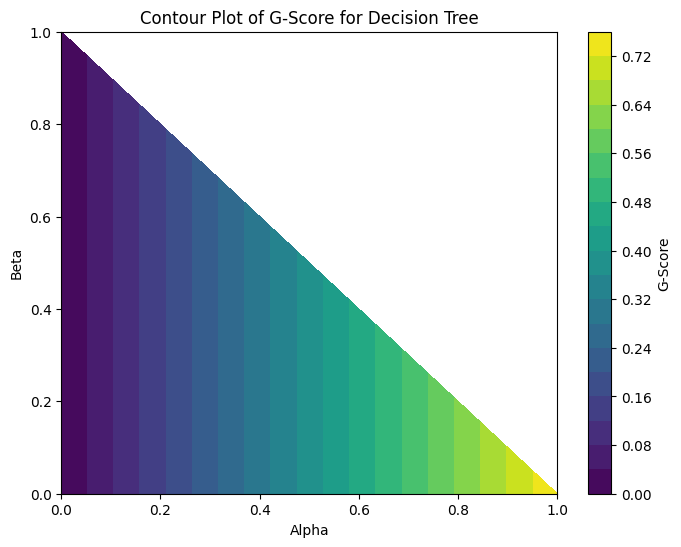

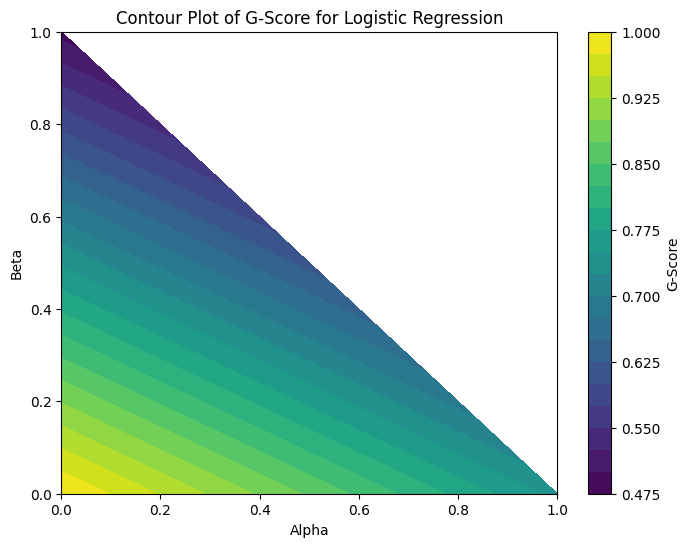

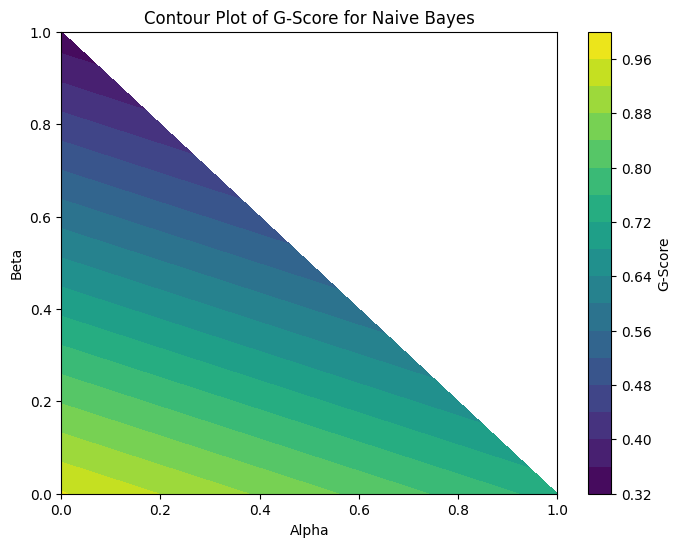

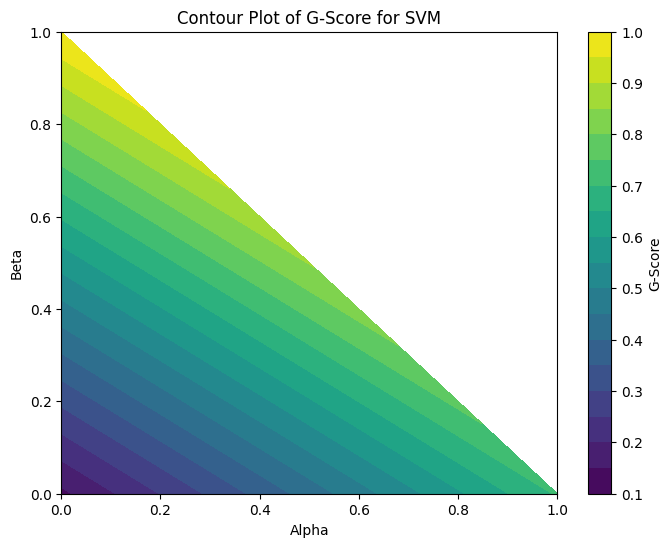

In [14]:
import numpy as np
import matplotlib.pyplot as plt

alpha_values = np.linspace(0, 1, 20)
beta_values = np.linspace(0, 1, 20)

for model in averages_df["Model"]:
    f1 = averages_df[averages_df["Model"] == model]["F1_Score"].values[0]
    train = averages_df[averages_df["Model"] == model]["FTTSE_Training_norm"].values[0]
    inference = averages_df[averages_df["Model"] == model]["FTTSE_Inference_norm"].values[0]

    g_scores = np.empty((len(alpha_values), len(beta_values)))

    for i, alpha in enumerate(alpha_values):
        for j, beta in enumerate(beta_values):
            gamma = 1 - alpha - beta
            if gamma >= 0:
                g_scores[i, j] = calculate_G_score(alpha, beta, gamma, f1, train, inference).mean()
            else:
                g_scores[i, j] = np.nan

    plt.figure(figsize=(8, 6))
    plt.contourf(alpha_values, beta_values, g_scores.T, levels=20, cmap='viridis')
    plt.colorbar(label='G-Score')
    plt.xlabel('Alpha')
    plt.ylabel('Beta')
    plt.title(f'Contour Plot of G-Score for {model}')
    plt.show()


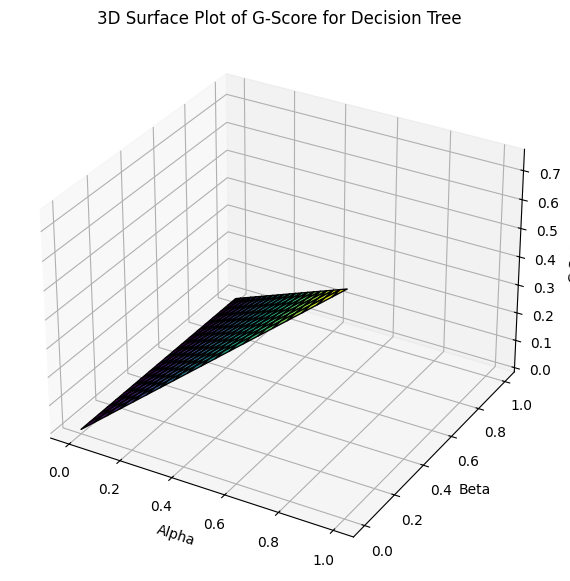

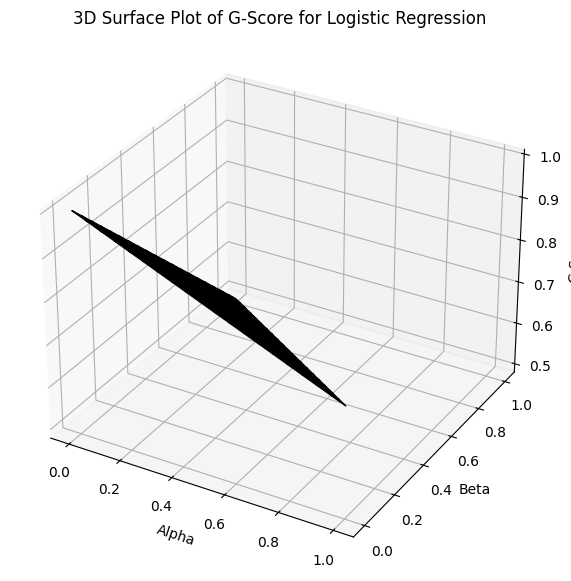

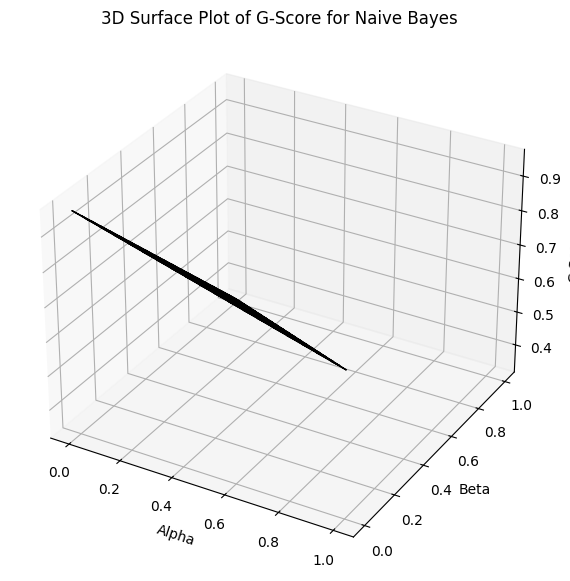

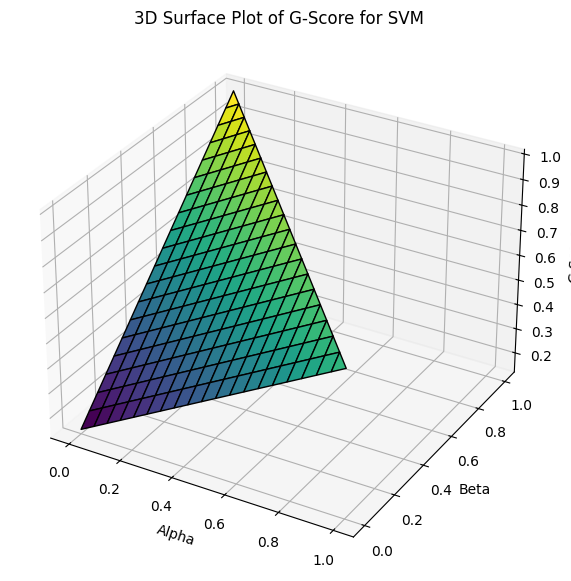

In [15]:
from mpl_toolkits.mplot3d import Axes3D
import numpy as np
import matplotlib.pyplot as plt

alpha_values = np.linspace(0, 1, 20)
beta_values = np.linspace(0, 1, 20)

for model in averages_df["Model"]:
    f1 = averages_df[averages_df["Model"] == model]["F1_Score"].values[0]
    train = averages_df[averages_df["Model"] == model]["FTTSE_Training_norm"].values[0]
    inference = averages_df[averages_df["Model"] == model]["FTTSE_Inference_norm"].values[0]

    X, Y = np.meshgrid(alpha_values, beta_values)
    Z = np.empty_like(X)

    for i in range(len(alpha_values)):
        for j in range(len(beta_values)):
            alpha = X[i, j]
            beta = Y[i, j]
            gamma = 1 - alpha - beta
            if gamma >= 0:
                Z[i, j] = calculate_G_score(alpha, beta, gamma, f1, train, inference).mean()
            else:
                Z[i, j] = np.nan

    fig = plt.figure(figsize=(10, 7))
    ax = fig.add_subplot(111, projection='3d')
    ax.plot_surface(X, Y, Z, cmap='viridis', edgecolor='k')
    ax.set_xlabel('Alpha')
    ax.set_ylabel('Beta')
    ax.set_zlabel('G-Score')
    ax.set_title(f'3D Surface Plot of G-Score for {model}')
    plt.show()


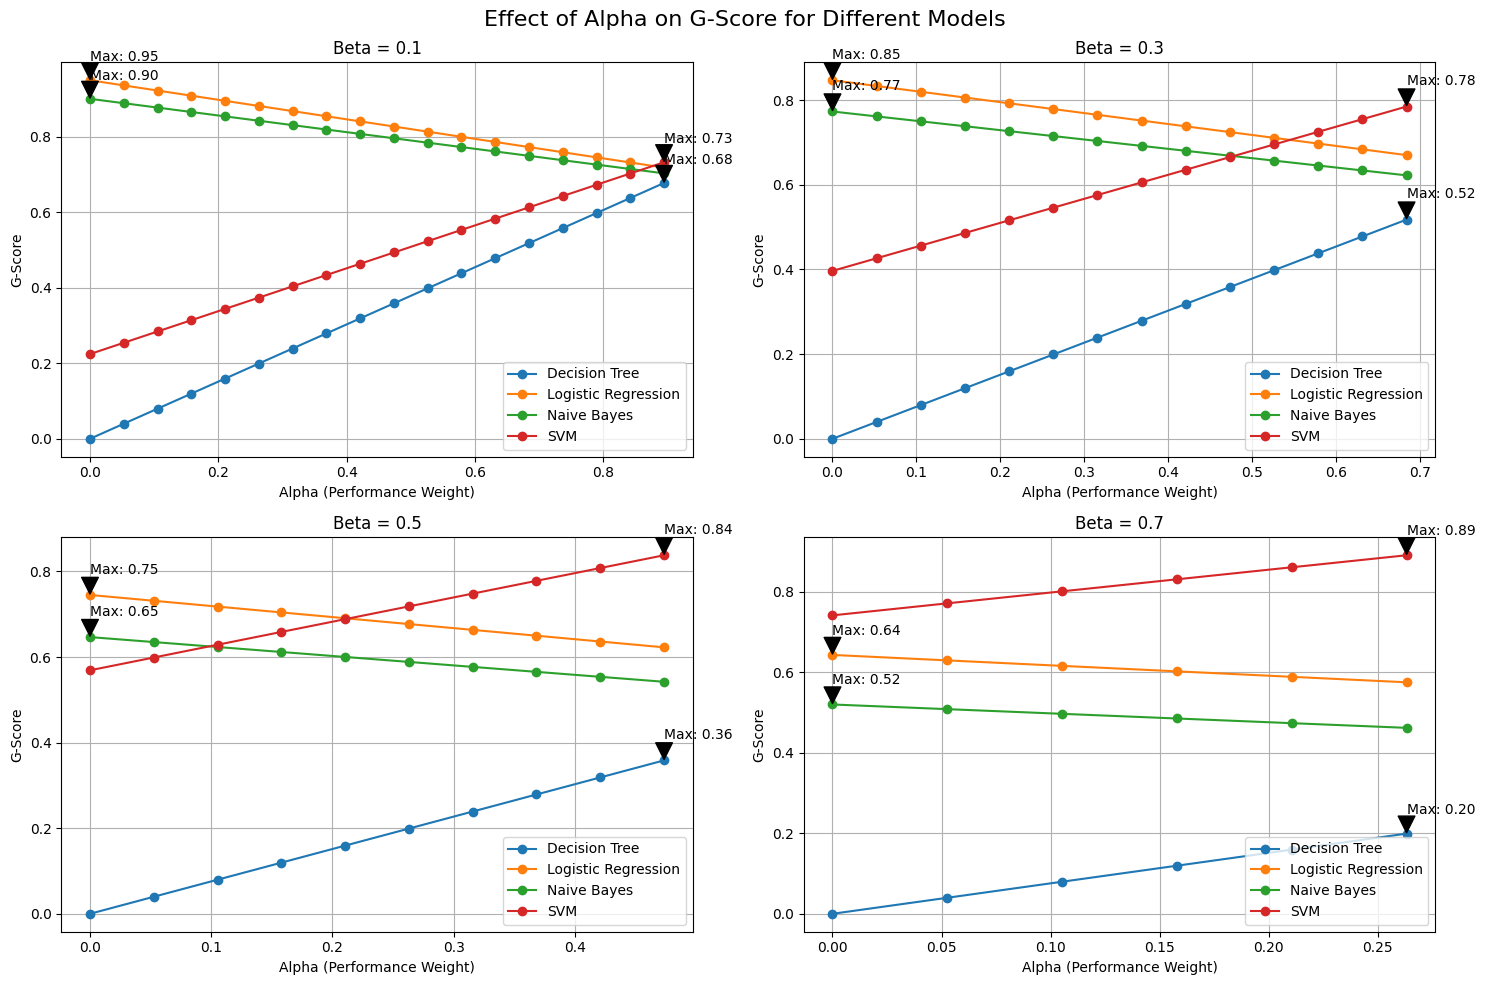

In [16]:
alpha_values = np.linspace(0, 1, 20)
beta_values = [0.1, 0.3, 0.5, 0.7]

fig, axs = plt.subplots(2, 2, figsize=(15, 10))
axs = axs.flatten()

for idx, beta_value in enumerate(beta_values):
    ax = axs[idx]
    for model in averages_df["Model"]:
        f1 = averages_df[averages_df["Model"] == model]["F1_Score"].values[0]
        train = averages_df[averages_df["Model"] == model]["FTTSE_Training_norm"].values[0]
        inference = averages_df[averages_df["Model"] == model]["FTTSE_Inference_norm"].values[0]

        g_scores = []
        for alpha in alpha_values:
            gamma = 1 - alpha - beta_value
            if gamma >= 0:
                g_score = calculate_G_score(alpha, beta_value, gamma, f1, train, inference)
                g_scores.append(g_score.mean())
            else:
                g_scores.append(np.nan)

        max_g_score = np.nanmax(g_scores)
        max_alpha = alpha_values[np.nanargmax(g_scores)]

        ax.plot(alpha_values, g_scores, marker='o', label=f'{model}')
        ax.annotate(f'Max: {max_g_score:.2f}', xy=(max_alpha, max_g_score),
                    xytext=(max_alpha, max_g_score + 0.05),
                    arrowprops=dict(facecolor='black', shrink=0.05))

    ax.set_xlabel('Alpha (Performance Weight)')
    ax.set_ylabel('G-Score')
    ax.set_title(f'Beta = {beta_value}')
    ax.grid(True)
    ax.legend()

fig.suptitle('Effect of Alpha on G-Score for Different Models', fontsize=16)
plt.tight_layout()
plt.show()


In [17]:
import pandas as pd

alpha_values = np.linspace(0, 1, 20)
beta_values = np.linspace(0, 1, 20)

optimal_params = []

for model in averages_df["Model"]:
    f1 = averages_df[averages_df["Model"] == model]["F1_Score"].values[0]
    train = averages_df[averages_df["Model"] == model]["FTTSE_Training_norm"].values[0]
    inference = averages_df[averages_df["Model"] == model]["FTTSE_Inference_norm"].values[0]

    max_g_score = -np.inf
    opt_alpha, opt_beta, opt_gamma = None, None, None

    for alpha in alpha_values:
        for beta in beta_values:
            gamma = 1 - alpha - beta
            if gamma >= 0:
                g_score = calculate_G_score(alpha, beta, gamma, f1, train, inference).mean()
                if g_score > max_g_score:
                    max_g_score = g_score
                    opt_alpha, opt_beta, opt_gamma = alpha, beta, gamma

    optimal_params.append({
        "Model": model,
        "Alpha": opt_alpha,
        "Beta": opt_beta,
        "Gamma": opt_gamma,
        "Max G-Score": max_g_score
    })

optimal_params_df = pd.DataFrame(optimal_params)
print(optimal_params_df)


                 Model  Alpha  Beta  Gamma  Max G-Score
0        Decision Tree    1.0   0.0    0.0     0.756857
1  Logistic Regression    0.0   0.0    1.0     1.000000
2          Naive Bayes    0.0   0.0    1.0     0.963202
3                  SVM    0.0   1.0    0.0     1.000000
